In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_dir = os.getcwd()
input_file= os.path.join(input_dir, 'DAL.csv')

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv(input_file,index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-05-03,21.750000,21.950001,20.549999,20.719999,18.405600,8052800
2007-05-04,21.250000,21.350000,20.700001,20.980000,18.636560,5437300
2007-05-07,21.200001,21.290001,20.200001,20.360001,18.085817,2646300
2007-05-08,20.000000,20.000000,19.299999,19.629999,17.437353,4166100
2007-05-09,19.750000,20.200001,19.629999,19.790001,17.579481,7541100
...,...,...,...,...,...,...
2020-08-03,24.850000,25.480000,24.379999,25.200001,25.200001,16590400
2020-08-04,25.450001,26.219999,25.309999,25.670000,25.670000,17233600
2020-08-05,26.219999,27.040001,25.750000,26.469999,26.469999,29661100


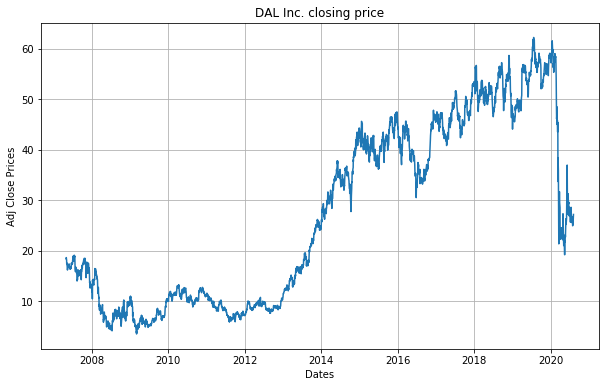

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adj Close Prices')
plt.plot(df['Adj Close'])
plt.title('DAL Inc. closing price')
plt.show()

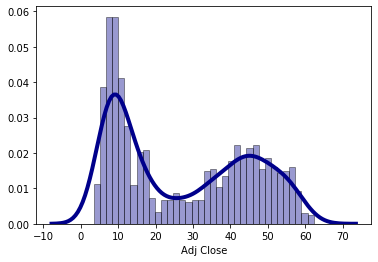

In [4]:
# Distribution of Adj Close
import seaborn as sns
sns.distplot(df['Adj Close'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
df_close = df['Adj Close']

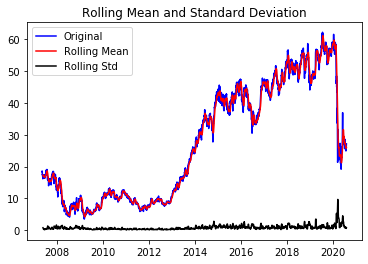

Results of Dickey-Fuller Test
Test Statistics                  -1.236842
p-value                           0.657550
No. of lags used                  8.000000
Number of observations used    3332.000000
critical value (1%)              -3.432314
critical value (5%)              -2.862408
critical value (10%)             -2.567232
dtype: float64


In [12]:
# Check stationarity
# ADF Test
# Null Hyp: The series has unit root (alpha = 1)
# Alter Hyp: The series has no unit root

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey-Fuller Test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

The p-value is 0.657550 >0.05, we reject the Null Hypothesis. Thus, series is not sationary.

<Figure size 432x288 with 0 Axes>

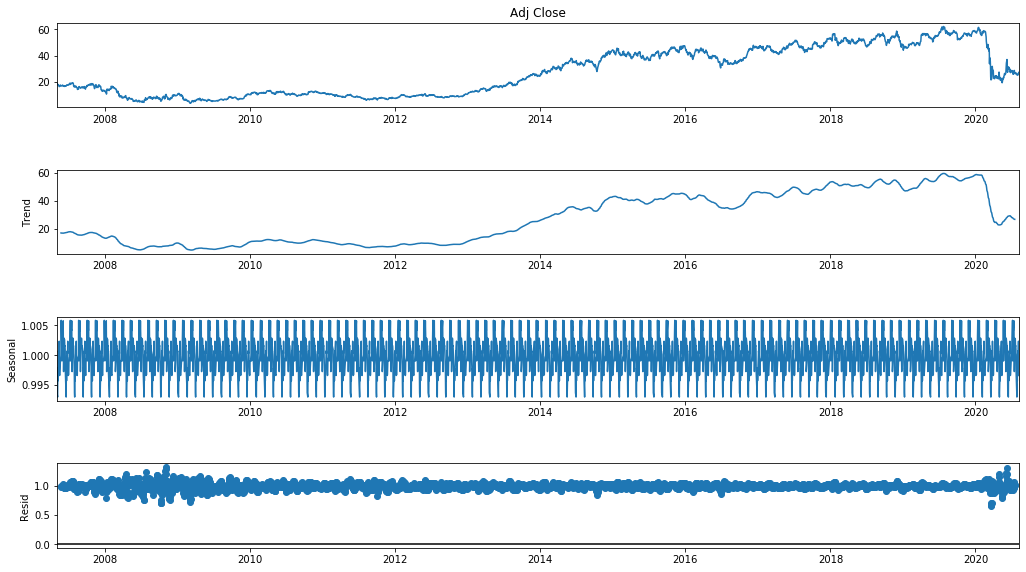

In [7]:
# Seperate Trends (Inceasing or decresing value) and Seasonality (Repeating short-term cycle)

result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


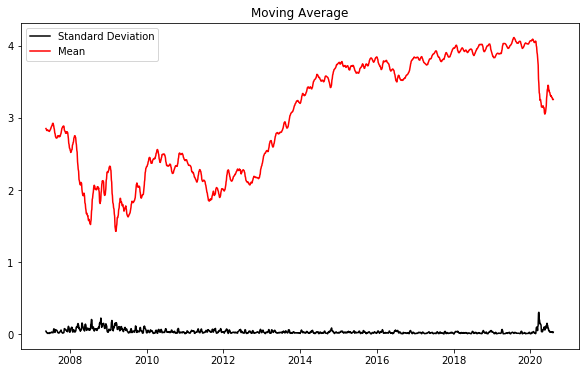

In [9]:
# Reduce Magnitude of values and rising trends in series by log
# Rolling average is calculated as past 12 months 

plt.figure(figsize=(10,6))
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [9]:
df_log
df_log[:int(len(df_log)*0.9)]

Date
2007-05-03    2.912655
2007-05-04    2.925125
2007-05-07    2.895128
2007-05-08    2.858615
2007-05-09    2.866732
                ...   
2019-04-04    4.020201
2019-04-05    4.029075
2019-04-08    4.028728
2019-04-09    4.015471
2019-04-10    4.031324
Name: Adj Close, Length: 3006, dtype: float64

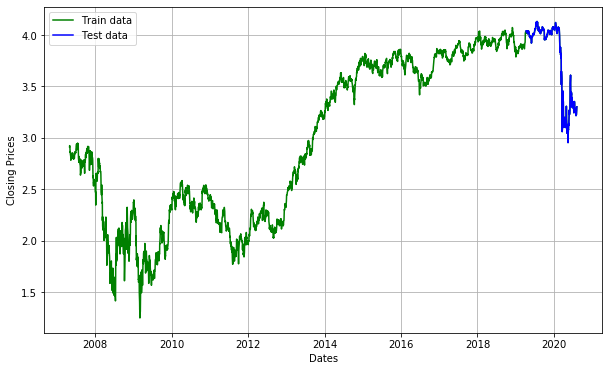

In [16]:
# Split Series into Train and Test
# Green as Train
# Blue as Test

train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

In [17]:
# use auto_arima to optimal choose p,q,d

from pmdarima import auto_arima

model_auto_ARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11863.919, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11862.135, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11862.135, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11865.550, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11860.132, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3006
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5933.775
Date:                Sun, 09 Aug 2020   AIC                         -11865.550
Time:                        20:55:46   BIC                         -11859.542
Sample:                             0   HQIC                        -11863.389
                               - 3006                             

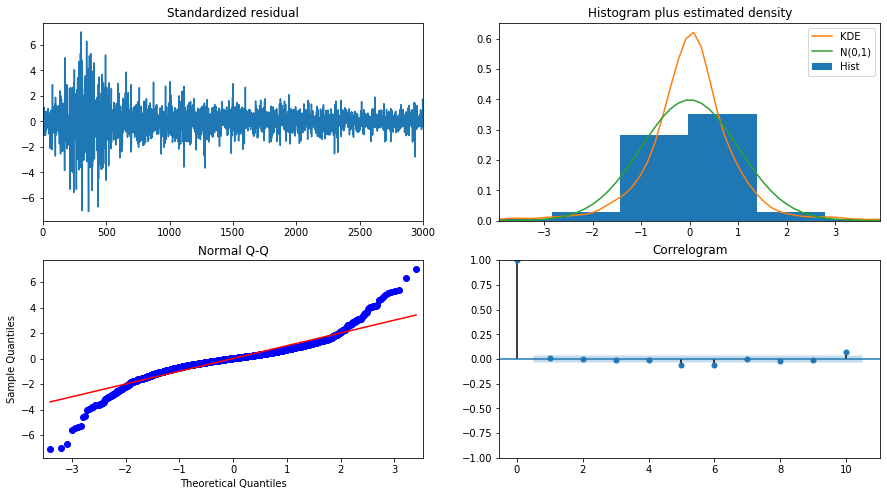

In [18]:
# The optimal p, d, q is under SARIMAX class.

model_auto_ARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top Left: The residuals fluctuate around 0, and most residuals fluctuate in index range (0, 500).

Top Right: The density plot suggest residuals are normal distrubuted.

Bot Left: All the dots should fall on Red Line. If it doesn't, the distribution is skewed.

Bot Right: Residual errors are not correlated. If adding more predictors, there would be a correlation.

In [19]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 3005
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5933.960
Method:                           css   S.D. of innovations              0.034
Date:                Sun, 09 Aug 2020   AIC                         -11863.919
Time:                        20:55:46   BIC                         -11851.903
Sample:                             1   HQIC                        -11859.598
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.608      0.543      -0.001       0.002


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


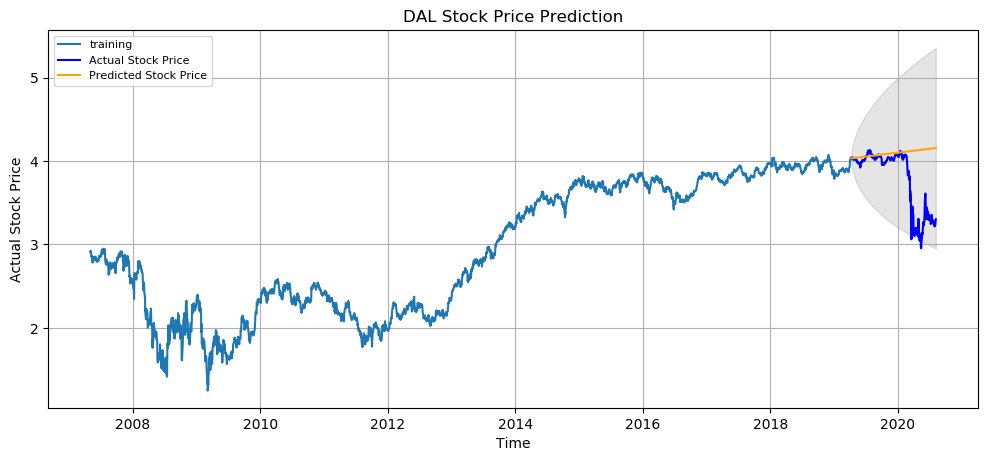

In [20]:
# Forecast
# Returns forecast samples, std of forecast, confidence interval

fc, se, conf = fitted.forecast(335, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.grid(True)
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('DAL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 0.25214133020192364
MAE: 0.3135502099622335
RMSE: 0.502136764439653
